In [268]:
# working through https://www.youtube.com/watch?v=qFJeN9V1ZsI&t=143s

In [269]:
import numpy as np
from random import randint
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

In [270]:
# GPU check
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: {}\nDevice: {}".format(len(physical_devices), physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available: 1
Device: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Generate data
- Experimental drug tested on ages 13 - 90
- 3200 participants. Half less than age 55 and half > 55
- 95% of patients below 55 had no side-effects
- 95% of patients above 55 had side-effects

In [271]:
def generate_data(negative_samples_count, positive_samples_count):
    train_labels = []
    train_samples = []

    for i in range(negative_samples_count):
        if (i % 2) == 0:
            # % < 55 with side-effects
            sample_age = randint(13, 55)
            train_samples.append(sample_age)
            train_labels.append(1)

        else:
            # % > 55 with no-sideeffects
            sample_age = randint(56, 90)
            train_samples.append(sample_age)
            train_labels.append(0)

    for i in range(positive_samples_count):
        if (i % 2) == 0: 
            # % < 55 with no side-effects
            sample_age = randint(13, 55)
            train_samples.append(sample_age)
            train_labels.append(0)
        else:
            # % > 55 with side-effects
            sample_age = randint(56, 90)
            train_samples.append(sample_age)
            train_labels.append(1)

    return train_samples, train_labels
        
n_train = 3200
n_test = 400
train_samples, train_labels = generate_data(int(0.05 * n_train), n_train - int(0.05 * n_train))
test_samples, test_labels = generate_data(int(0.05 * n_test), n_test - int(0.05 * n_test))

In [272]:
train_samples, train_labels = shuffle(np.array(train_samples), np.array(train_labels))
test_samples, test_labels = shuffle(np.array(test_samples), np.array(test_labels))

In [273]:
scaler = MinMaxScaler(feature_range=(0, 1))
# (n_samples x n_dims)
scaled_train_samples = scaler.fit_transform(train_samples.reshape(-1, 1))
scaled_test_samples = scaler.fit_transform(test_samples.reshape(-1, 1))

## Keras sequential model

- Create a simple 3 layer NN using the Sequential API. 

In [274]:
model = Sequential([
    Dense(units=16, input_shape=(1, ),  activation="relu"),
    Dense(units=32, activation="relu"),
    Dense(units=2, activation="softmax")
])

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 16)                32        
_________________________________________________________________
dense_49 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_50 (Dense)             (None, 2)                 66        
Total params: 642
Trainable params: 642
Non-trainable params: 0
_________________________________________________________________


In [275]:
model.compile(optimizer = Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [276]:
model.fit(x=scaled_train_samples, y=train_labels, validation_split=0.1, batch_size=10, epochs=30, shuffle=True, verbose=2)

Epoch 1/30
288/288 - 0s - loss: 0.6704 - accuracy: 0.5882 - val_loss: 0.6496 - val_accuracy: 0.6531
Epoch 2/30
288/288 - 0s - loss: 0.6257 - accuracy: 0.7080 - val_loss: 0.6003 - val_accuracy: 0.7531
Epoch 3/30
288/288 - 0s - loss: 0.5794 - accuracy: 0.7812 - val_loss: 0.5542 - val_accuracy: 0.8156
Epoch 4/30
288/288 - 0s - loss: 0.5336 - accuracy: 0.8198 - val_loss: 0.5073 - val_accuracy: 0.8469
Epoch 5/30
288/288 - 0s - loss: 0.4892 - accuracy: 0.8490 - val_loss: 0.4642 - val_accuracy: 0.8813
Epoch 6/30
288/288 - 0s - loss: 0.4475 - accuracy: 0.8750 - val_loss: 0.4240 - val_accuracy: 0.9125
Epoch 7/30
288/288 - 0s - loss: 0.4110 - accuracy: 0.8917 - val_loss: 0.3910 - val_accuracy: 0.9125
Epoch 8/30
288/288 - 0s - loss: 0.3813 - accuracy: 0.9003 - val_loss: 0.3652 - val_accuracy: 0.9187
Epoch 9/30
288/288 - 0s - loss: 0.3579 - accuracy: 0.9118 - val_loss: 0.3447 - val_accuracy: 0.9281
Epoch 10/30
288/288 - 0s - loss: 0.3395 - accuracy: 0.9163 - val_loss: 0.3295 - val_accuracy: 0.9281

## Predictions on a test set

In [277]:
predictions = model.predict(x=scaled_test_samples)
print(predictions[:10])

[[0.90841365 0.09158632]
 [0.980431   0.01956897]
 [0.97948897 0.02051107]
 [0.7005283  0.29947168]
 [0.9805376  0.01946241]
 [0.31532016 0.6846798 ]
 [0.8008381  0.19916189]
 [0.123333   0.87666696]
 [0.8008381  0.19916189]
 [0.9786993  0.02130067]]


In [278]:
rounded_predictions = np.argmax(predictions, axis=1)

### Plot confusion matrix

In [279]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [280]:
def plot_confusion_matrix(mat, classes):
    cmap = plt.cm.Blues
    plt.imshow(mat, interpolation='nearest', cmap=cmap)
    plt.title("Side effect vs No side effect")
    
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks,  classes)
    
    print(mat)
    
    threshold = mat.max()/2
    
    for i, j in itertools.product(range(mat.shape[0]), range(mat.shape[1])):
        plt.text(j, i, mat[i, j],
                 horizontalalignment="center", color="white" if mat[i, j] > threshold else "black")
    plt.tight_layout()
    plt.ylabel("True label")

    plt.xlabel("Predicted label")

In [281]:
c_mat = confusion_matrix(test_labels, rounded_predictions)

[[189  11]
 [  9 191]]


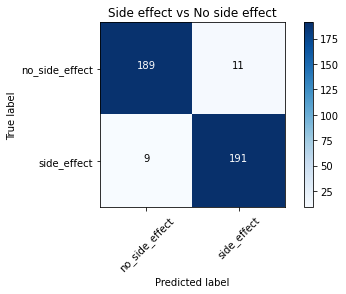

In [282]:
classes = ["no_side_effect", "side_effect"]
plot_confusion_matrix(c_mat, classes)

# Saving and Loading a Model

### Save and load everything
    - Saves architecture
    - Saves weights
    - Training configuration (Loss and optimizer used)
    - The state of the optimizer, allowing you to continue training.

In [287]:
import os.path

if os.path.isfile("models/keras101.h5") is False:
    model.save("models/keras101.h5")
else:
    print("Path exists. Override if you must")
    
# Save as json only the architecture. Load with model_from_json(mode.to_json())
# model.to_json().save("<path>")

# Save only the weights with model.save_weights("<path>"). 
# Create new model 
# new_model = Sequential([
#     Dense(units=16, input_shape=(1, ),  activation="relu"),
#     Dense(units=32, activation="relu"),
#     Dense(units=2, activation="softmax")
# ])
# Load weights into this model
# new_model.load_weights("<path>")

Path exists. Override if you must


In [288]:
from tensorflow.keras.models import load_model
new_model = load_model("models/keras101.h5")

In [289]:
new_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 16)                32        
_________________________________________________________________
dense_46 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_47 (Dense)             (None, 2)                 66        
Total params: 642
Trainable params: 642
Non-trainable params: 0
_________________________________________________________________


In [290]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 16)                32        
_________________________________________________________________
dense_49 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_50 (Dense)             (None, 2)                 66        
Total params: 642
Trainable params: 642
Non-trainable params: 0
_________________________________________________________________
